# A simple example

TOPP-RA solves the time-optimal path-parametrization (TOPP) problem: given a geometric
path and constraints, compute the fastest way to traverse the geometric path without
violating these given constraints.

In this tutorial, we consider the most basic usecase of TOPP-RA: compute the time-optimal
time-parameterization subject to joint velocity and acceleration
constraints. 

## Problem setup

As an example, we randomly choose 5 waypoints and fit a cubic spline through
all five to obtain a geometric path. Similarly, we randomly sample a joint
acceleration and a joint velocity constraints.


In [2]:
# toppra
import toppra as ta
import toppra.constraint as constraint
import toppra.algorithm as algo
import numpy as np
# misc: for plotting and measuring time
import matplotlib.pyplot as plt
import time

In [4]:
# Random waypoints used to obtain a random geometric path. Here,
# we use spline interpolation.
dof = 6
np.random.seed(0)
way_pts = np.random.randn(5, dof)
path = ta.SplineInterpolator(np.linspace(0, 1, 5), way_pts)

Similarly, we choose a random set of velocity and acceleration constraints below.

A constraint can have different `discretization_scheme`: 
- `Interpolation` and 
- `Collocation`.

Generally, `Interpolation` leads to higher quality trajectory with a longer (slightly) computation time.

In [5]:
# Create velocity bounds, then velocity constraint object
vlim_ = np.random.rand(dof) * 20
vlim = np.vstack((-vlim_, vlim_)).T
# Create acceleration bounds, then acceleration constraint object
alim_ = np.random.rand(dof) * 2
alim = np.vstack((-alim_, alim_)).T
pc_vel = constraint.JointVelocityConstraint(vlim)
pc_acc = constraint.JointAccelerationConstraint(
   alim, discretization_scheme=constraint.DiscretizationType.Interpolation)

print(pc_acc)

JointAccelerationConstraint(
    Type: ConstraintType.CanonicalLinear
    Discretization Scheme: DiscretizationType.Interpolation
    Acceleration limit: 
      J1: [-1.33353343  1.33353343]
      J2: [-1.34127574  1.34127574]
      J3: [-0.42076512  0.42076512]
      J4: [-0.2578526  0.2578526]
      J5: [-0.6308567  0.6308567]
      J6: [-0.72742154  0.72742154]
)


Notice that in the above printout, we have 6 acceleration joint limits with `Interpolation` `discretization_scheme`.

## Solve TOPP

We now solve for the time-optimal path parametrization. An important parameter
to choose is the number of grid points. A larger number leads to trajectories
with higher quality, with the drawback of higher computational cost. In the
below example, we choose 200 gridpoints.

In [11]:
t0 = time.time()
# Setup a parametrization instance, then retime
gridpoints = np.linspace(0, path.duration, 200)
instance = algo.TOPPRA([pc_vel, pc_acc], path, gridpoints=gridpoints, solver_wrapper='seidel')
jnt_traj, aux_traj, int_data = instance.compute_trajectory(0, 0, return_data=True)
print("Parameterization time: {:} secs".format(time.time() - t0))

Parameterization time: 0.0300650596619 secs


There are muliple solver wrapper to choose from: `seidel`, `hotqpoases`, `cvxpy`, etc.
In general you should choose `seidel` because it is much faster than `hotqpoases`. However,
be warned that `seidel` can fail for ill-posed path parametrization instances. 

Below we solve
the same problem using different solver wrappers and compare their speeds.

In [13]:
for solver_wrapper in ['seidel', 'hotqpoases', 'cvxpy']:
    t0 = time.time()
    instance = algo.TOPPRA([pc_vel, pc_acc], path, gridpoints=gridpoints, solver_wrapper=solver_wrapper)
    traj, _ = instance.compute_trajectory(0, 0)
    print("{:20}: comp. time {:.4f} secs: traj dur. {:4f} sec".format(solver_wrapper, time.time() - t0, traj.get_duration()))

seidel              : comp. time 0.0173 secs: traj dur. 17.912383 sec
hotqpoases          : comp. time 0.0689 secs: traj dur. 17.912383 sec
cvxpy               : comp. time 2.9252 secs: traj dur. 17.912386 sec


## Inspect solution


The time-optimally retimed geometric path can be recovered easily.

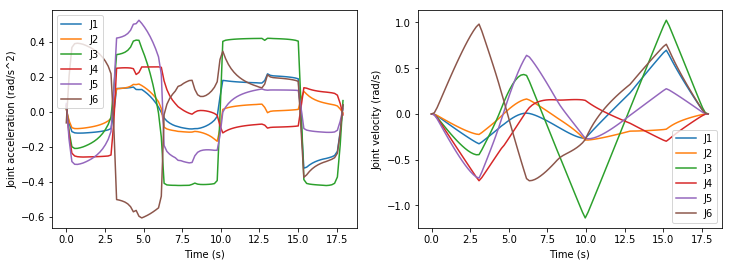

In [14]:
ts_sample = np.linspace(0, jnt_traj.get_duration(), 100)
qdds_sample = jnt_traj.evaldd(ts_sample)
qds_sample = jnt_traj.evald(ts_sample)

fig, axs = plt.subplots(1, 2, sharex=True, figsize=[12, 4])
for i in range(6):
    axs[0].plot(ts_sample, qdds_sample[:, i], label="J{:d}".format(i + 1))
    axs[1].plot(ts_sample, qds_sample[:, i], label="J{:d}".format(i + 1))
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Joint acceleration (rad/s^2)")
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Joint velocity (rad/s)")
plt.show()

We can also inspect the solution in detail by looking at the returned `int_data` dictionary: The controllable sets and the time-optimal parametrization are plotted below.

It is not hard to see that the returned parametrization (blue) is the fastest possible!

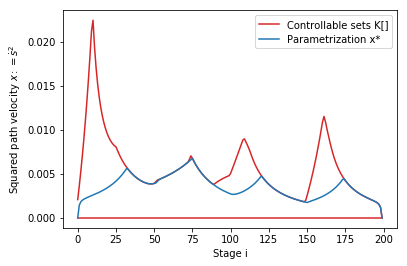

In [15]:
plt.plot(int_data['K'][:, 0], c='C3', label="Controllable sets K[]")
plt.plot(int_data['K'][:, 1], c='C3')
plt.plot(int_data['sd'] ** 2, label="Parametrization x*")
plt.legend()
plt.xlabel("Stage i")
plt.ylabel("Squared path velocity $x:=\dot s^2$")
plt.show()